In [2]:
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
import os
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.transforms import v2
from torchvision import transforms
import torchvision.transforms.functional as TF
import random

In [3]:
def download_images_from_excel(excel_file, sheet_name,image_column, brand_column, output_folder):
    '''This function downloads the images from the excel in a folder -- use only fist time'''
    # Read Excel file
    df = pd.read_excel(excel_file, sheet_name=sheet_name)
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    # Iterate through rows and download images
    for index, row in df.iterrows():
        image_url = row[image_column]
        brand_name = row[brand_column]
        try:
            response = requests.get(image_url)
            if response.status_code == 200:
                # Open image from the response
                image = Image.open(BytesIO(response.content))
                # Convert image to JPEG format
                if image.format != 'JPEG':
                    image = image.convert('RGB')
                # Save image to the output folder with brand name as filename
                image_path = os.path.join(output_folder, f"{brand_name}.jpg")
                image.save(image_path, "JPEG")
                #print(f"Image for {brand_name} downloaded successfully.")
            else:
                print(f"Failed to download image for {brand_name}. Status code: {response.status_code}")
        except Exception as e:
            print(f"Failed to download image for {brand_name}. Error: {e}")

In [4]:
EXCEL_FILE = r"C:\Users\Desktop\merged_data.xlsx" # path where excel is saved
SHEET_NAME = 'Sheet1'
IMAGE_COLUMN = 'exampleUrl'
BRAND_COLUMN = 'name'
IMAGE_DIR = r"C:\Users\CarolinaSoria\Desktop\ml basics\machine-learning-basics\data_augmentation\monet_images" # path where images will be saved
AUGMENTED_OUTPUT_DIR = "augmented_images"
IMAGE_FILENAMES = [f for f in os.listdir(IMAGE_DIR) if os.path.isfile(os.path.join(IMAGE_DIR, f))]

In [5]:
if __name__ == "__main__":
    excel_file = EXCEL_FILE
    sheet_name = SHEET_NAME
    image_column = IMAGE_COLUMN
    brand_column = BRAND_COLUMN
    image_directory = IMAGE_DIR
    #download_images_from_excel(excel_file, sheet_name, image_column, brand_column, image_directory)

In [3]:
def define_image_paths(image_directory):
    '''
    Find paths of images to process them later.
    Input = directory (str)
    Output = list of image paths
    '''
    image_paths = []
    for dirpath, _, filenames in os.walk(image_directory):
        for filename in filenames:
            # Check if the file is an image (e.g., jpg or png)
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_path = os.path.join(dirpath, filename)
                image_paths.append(image_path)
    return image_paths

def image_to_tensor(image_paths):
    '''
    Turn image to tensor format and normalize.
    Input = image paths as list
    Output = list of tensors
    '''
    tensor_images = []
    for path in image_paths:
        img = Image.open(path)
        transform_to_tensor=v2.Compose([v2.ToTensor()])
        img = transform_to_tensor(img)
        tensor_images.append(img)
    return tensor_images

def rgb_to_rgba(images):
    '''
    Turn RGB to RGBA format
    Input: RGB images (list)
    Output: RGBA images (list)
    '''
    rgba_images = []
    for img in images:
        alpha_channel = torch.full((1, img.shape[1], img.shape[2]), 255, dtype=torch.uint8)
        rgba_image = torch.cat((img, alpha_channel), dim=0)
        rgba_images.append(rgba_image)
    return rgba_images

def tensor_to_pil(images):
    '''
    Turn image to PIL format. .
    Input: tensor images (list)
    Output: PIL imges (list)
    '''
    pil_images = []
    for img in images:
        pil_image = TF.to_pil_image(img)
        pil_images.append(pil_image)
    return pil_images

def rotate(images, angle):
    '''
    This function transforms PIL images to RGBA and rotates them. Then, it turns them back into tensors.
    Inputs: RGB images list as PIL format (list), rotation angle (int or float).
    Output: rotated PIL images (list). NOTE: the images are not turned back into tensors because they need to be in PIL format for saving them later.
    '''
    rotated_images = []
    for img in images:
        rgba_img = img.convert('RGBA')
        rotated_img = torchvision.transforms.functional.rotate(rgba_img, angle, fill=(0, 0, 0, 0), expand=True)
        rotated_images.append(rotated_img)
    return rotated_images 

def apply(images, aug):
    '''
    Apply augmentation.
    Input: tensors (list), augmentation (pytorch)
    Output: augmented images as tensors (list)
    '''
    augmented_images = []
    for img in images:
        Y = aug(img)
        augmented_images.append(Y)
    return augmented_images

def display_images(indices, images, image_format):
    ''' 
    Display images visually.
    Input: tensors (list), list indices(as a list of numbers), input image format ('PIL' or 'tensor').
    Output: PIL image as display
    '''
    for idx in indices:
        if image_format == 'tensor':
            # Display tensor image
            image_tensor = images[idx]
            plt.imshow(TF.to_pil_image(image_tensor))
        elif image_format == 'PIL':
            # Display PIL image
            pil_image = images[idx]
            plt.imshow(pil_image)


In [4]:
image_paths = define_image_paths(IMAGE_DIR)
tensor_images = image_to_tensor(image_paths)

c:\Users\CarolinaSoria\anaconda3\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [5]:
gaussian_blur = v2.Compose([v2.GaussianBlur(kernel_size=(7, 7), sigma=(0.1, 5))]) # gaussian blur augmentation
color_jitter = v2.ColorJitter(brightness=0.5, contrast=0, saturation=0, hue=0) # color jitter augmentation
shape_aug = v2.RandomResizedCrop((200, 200), scale=(0.1, 1), ratio=(0.5, 2)) # shape augmentation
random_affine = v2.RandomAffine(45) # random affine augmentation

In [6]:
# TRANSFORMATIONS
blurred = apply(tensor_images, gaussian_blur)
cropped = apply(tensor_images, shape_aug)
random_affine = apply(tensor_images, random_affine)

pil_images = tensor_to_pil(tensor_images) # for rotation and jitter, we first need to convert tensors into PIL images
rotated_45 = rotate(pil_images, angle=45)
rotated_90 = rotate(pil_images, angle=90)
rotated_30 = rotate(pil_images, angle=30)
jittered = apply(pil_images, color_jitter)

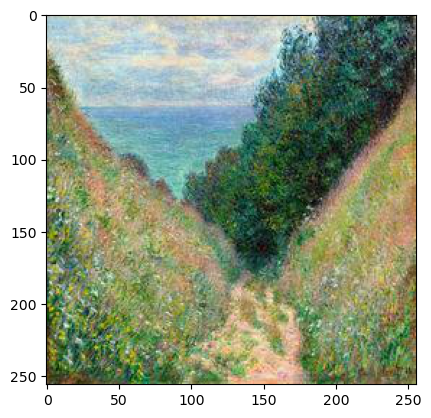

In [7]:
display_images([27], tensor_images, image_format='tensor') # original format

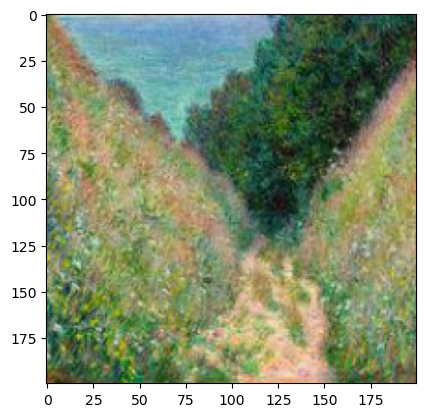

In [8]:
display_images([27], cropped, image_format='tensor')

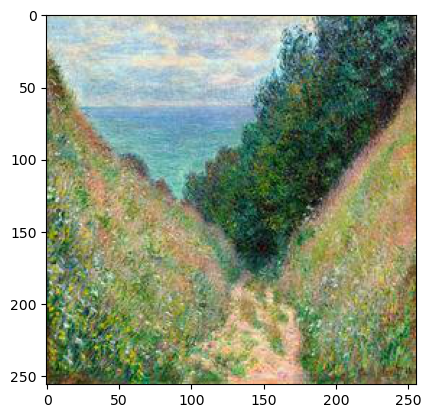

In [9]:
display_images([27], jittered, image_format='PIL')

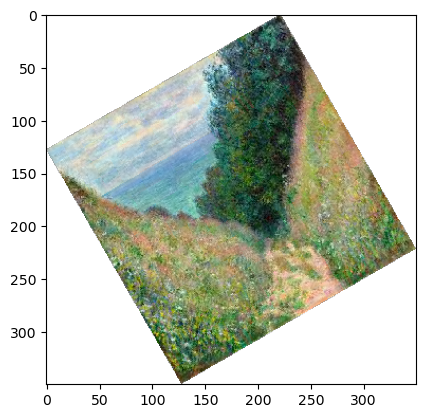

In [10]:
display_images([27], rotated_30, image_format='PIL')

In [11]:
augmented_output_dir = AUGMENTED_OUTPUT_DIR
image_filenames = IMAGE_FILENAMES
os.makedirs(augmented_output_dir, exist_ok=True)
    # Create subfolders for each logo
for logo_name in image_filenames:
    logo_folder = os.path.join(augmented_output_dir, logo_name)
    os.makedirs(logo_folder, exist_ok=True)

    # Save each augmented image in the corresponding subfolder
for i, (original_img, blurred_img, cropped_img, affine_img, rotated_1, rotated_2, rotated_3, jittered_img ) in enumerate(zip(tensor_images, blurred, cropped, random_affine, rotated_45, rotated_30, rotated_90, jittered)):
    logo_name = image_filenames[i]
    logo_folder = os.path.join(augmented_output_dir, logo_name)
    
    original_pil = TF.to_pil_image(original_img)
    blurred_pil = TF.to_pil_image(blurred_img)
    cropped_pil = TF.to_pil_image(cropped_img)
    affined_pil = TF.to_pil_image(affine_img)
    rotated_pil_1, rotated_pil_2, rotated_pil_3 = rotated_1, rotated_2, rotated_3
    jittered_pil = jittered_img

        # save PIL images
    original_pil.save(os.path.join(logo_folder, f"original_{i}.png"))
    blurred_pil.save(os.path.join(logo_folder, f"blurred_{i}.png"))
    cropped_pil.save(os.path.join(logo_folder, f"cropped_{i}.png"))
    affined_pil.save(os.path.join(logo_folder, f"affined_{i}.png"))
    rotated_pil_1.save(os.path.join(logo_folder, f"rotated_45_{i}.png"))
    rotated_pil_2.save(os.path.join(logo_folder, f"rotated_30_{i}.png"))
    rotated_pil_3.save(os.path.join(logo_folder, f"rotated_90_{i}.png"))
    jittered_pil.save(os.path.join(logo_folder, f"jittered_{i}.png"))